In [486]:
import warnings

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

In [487]:
from sklearn.datasets import load_wine

data = load_wine()

In [488]:
X_original = np.array(data['data'])
Y = np.array(data['target'], dtype=int)

In [489]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, Y):
    X_train, Y_train = X[train_index, :], Y[train_index]
    X_test, Y_test = X[test_index, :], Y[test_index]
    
X_train, Y_train = X_original, Y
X_test, Y_test = X_original, Y

In [490]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [491]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

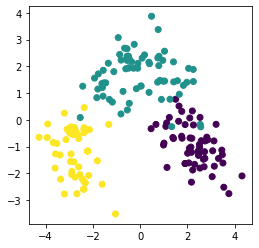

In [492]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)

In [493]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy_score(Y_test, Y_test_pred)

0.9606741573033708

In [494]:
def loss(X, Y, W, e, c):
    Y = Y[: ,None]
    T = np.where(np.equal(Y, Y.T), 1, -1)
    N = np.sum(T == 1, 1) - 1
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    return (np.sum(np.square(W)) / 2 +
            c * np.sum(np.maximum(np.sum(np.maximum(T * (D + D.T - 2 * P - e) + 1, 0), 1) - N + 1, 0)))

In [495]:
def grad(X, Y, W, e, c):
    Y = Y[:, None]
    T = np.where(np.equal(Y, Y.T), 1, -1)
    N = np.sum(T == 1, 1) - 1
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e) + 1
    E = np.sum(np.maximum(Z, 0), 1) - N + 1
    V = np.logical_and((E > 0)[:, None], Z > 0) * T
    U = V + V.T
    dW = W + c * (X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
    de = -c * np.sum(V)
    return dW, de

In [496]:
def loss_grad(X, T, N, W, e, c):
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e) + 1
    E = np.sum(np.maximum(Z, 0), 1) - N + 1

    L = np.sum(np.square(W)) / 2 + c * np.sum(np.maximum(E, 0))

    V = np.logical_and((E > 0)[:, None], Z > 0) * T
    U = V + V.T

    dW = W + c * (X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
    de = -c * np.sum(V)

    return L, dW, de

In [497]:
def PSD(A):
    W, V = np.linalg.eigh(A)
    if np.any(W < 0):
        return V @ np.diag(np.maximum(W, 0)) @ V.T
    else:
        return A

In [498]:
def loss_grad(X, T, N, W, e, c):
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e) + 1
    E = np.sum(np.maximum(Z, 0), 1) - N + 1

    L = np.sum(np.square(W)) / 2 + c * np.sum(np.maximum(E, 0))

    V = np.logical_and((E > 0)[:, None], Z > 0) * T
    U = V + V.T

    dW = W + c * (X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
    de = -c * np.sum(V)

    return L, dW, de

c = 1
n, d = X_train_scaled.shape
W = np.zeros((d,d))
e = 0.0
lr = .001
lr_up = ((1+np.sqrt(5))/2) ** (1/10)
lr_down = ((1+np.sqrt(5))/2) ** -1
armijo = .000001;
escale = 10
max_steps = 99

X = X_train_scaled
T = np.where(np.equal(Y_train[:, None], Y_train[None, :]), 1, -1)
N = np.sum(T == 1, 1) - 1

print("step  lrn_rate    dW_mean  de_mean       loss W_nrm   L_mean      e")

L, dW, de = loss_grad(X, T, N, W, e, c)
for i in range(max_steps+1):
    W_norm_squared = np.sum(np.square(W))
    LOOE = (L - W_norm_squared / 2) / c / n
    print(f"{i:4d} {lr:.3e} {-np.mean(dW):10.3f} {-de:8d} {L:10.3f} {np.sqrt(W_norm_squared):5.3f} {LOOE:8.3f} {e:6.3f}")
    while True:
        W_new = W - lr * dW
        e_new = e - lr * escale * de
        # W_new = PSD(W_new)
        # e_new = np.maximum(e_new, 0)
        L_new, dW_new, de_new = loss_grad(X, T, N, W_new, e_new, c)
        if L - L_new >= armijo * lr * (np.sum(np.square(dW)) + lr * escale * np.square(de)):
            L, dW, de = L_new, dW_new, de_new
            W, e = W_new, e_new
            lr *= lr_up
            break
        else:
            lr *= lr_down 

step  lrn_rate    dW_mean  de_mean       loss W_nrm   L_mean      e
   0 1.000e-03   6281.963   -10032  21214.000 0.000  119.180  0.000
   1 2.014e-06  -1761.740    10674  19279.161 0.558  108.309 -0.193
   2 2.113e-06  -1560.574     9784  10694.865 0.507   60.083  0.022
   3 2.217e-06   -628.869     6157   4523.811 0.478   25.414  0.229
   4 2.327e-06    -57.903     1925   2850.731 0.463   16.015  0.366
   5 2.441e-06    -14.162     1460   2346.410 0.453   13.182  0.411
   6 2.562e-06     -0.255     1056   1951.546 0.445   10.963  0.446
   7 2.688e-06     25.862      718   1661.319 0.439    9.333  0.473
   8 2.821e-06     31.622      614   1432.201 0.434    8.046  0.493
   9 2.960e-06     31.432      587   1229.303 0.431    6.906  0.510
  10 3.106e-06     46.961      332   1067.008 0.429    5.994  0.527
  11 3.259e-06      2.673      413    943.861 0.428    5.302  0.538
  12 3.419e-06     47.116      244    849.606 0.428    4.773  0.551
  13 3.588e-06      9.376      303    781.443 0.

In [730]:
class Activation:
    def __init__(self, bias=0):
        self.bias = bias
        self.loss = np.frompyfunc(self._uloss, 1, 1)
        self.grad = np.frompyfunc(self._ugrad, 1, 1)

class ReLU(Activation):
    def __init__(self, bias=0):
        super().__init__(bias)
    
    def _uloss(self, x):
        x += self.bias
        if x > 0:
            return x
        else:
            return 0
    
    def _ugrad(self, x):
        x += self.bias
        if x > 0:
            return 1
        else:
            return 0
        
class LeakyReLU(Activation):
    def __init__(self, bias=0, alpha=1e-2):
        self.alpha = alpha
        super().__init__(bias)
    
    def _uloss(self, x):
        x += self.bias
        if x > 0:
            return x
        else:
            return self.alpha * x
    
    def _ugrad(self, x):
        x += self.bias
        if x > 0:
            return 1
        else:
            return self.alpha
        
class SmoothReLU(Activation):
    def __init__(self, bias=0):
        super().__init__(bias)
    
    def _uloss(self, x):
        x += self.bias
        if x > .5:
            return x
        elif x > -.5:
            return .5 * (x + .5) ** 2
        else:
            return 0
    
    def _ugrad(self, x):
        x += self.bias
        if x > .5:
            return 1
        elif x > -.5:
            return x + .5
        else:
            return 0

class Quadratic(Activation):
    def __init__(self, bias=0):
        super().__init__(bias)
    
    def _uloss(self, x):
        x += self.bias
        if x > 0:
            return x ** 2
        else:
            return 0
    
    def _ugrad(self, x):
        x += self.bias
        if x > 0:
            return 2 * x
        else:
            return 0

class Logistic(Activation):
    def __init__(self, bias=0):
        super().__init__(bias)
        self.bias += np.log(np.expm1(1)) - 1
    
    def _uloss(self, x):
        x += self.bias
        y = np.exp(x)
        if y == np.inf:
            return x
        else:
            return np.log1p(y)
    
    def _ugrad(self, x):
        x += self.bias
        y = np.exp(x)
        if y == np.inf:
            return 1
        else:
            return 1 - 1 / (1 + y)


class Sigmoid(Activation):
    def __init__(self, bias=0):
        super().__init__(bias)
    
    def _uloss(self, x):
        x += self.bias
        return 1 / (1 + np.exp(-x))
    
    def _ugrad(self, x):
        x += self.bias
        y = 1 / (1 + np.exp(-x))
        return y * (1 - y)


def loss_grad(X, T, N, W, e, c, inner, outer):
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        E = np.sum(inner.loss(Z), 1) - N
        L = np.sum(np.square(W)) / 2 + c * np.sum(outer.loss(E))
        V = outer.grad(E)[:, None] * inner.grad(Z) * T

    U = V + V.T

    dW = W + c * (X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
    de = -c * np.sum(V)

    return L, dW, de

c = 1
n, d = X_train_scaled.shape
W = np.zeros((d,d))
e = 0.0
lr = .001
lr_up = ((1+np.sqrt(5))/2) ** (1/10)
lr_down = ((1+np.sqrt(5))/2) ** -1
armijo = .000001;
escale = 10
max_steps = 10
inner = Logistic(1)
outer = Logistic(1)

X = X_train_scaled
T = np.where(np.equal(Y_train[:, None], Y_train[None, :]), 1, -1)
N = np.sum(T == 1, 1) - 1

print("step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e")

L, dW, de = loss_grad(X, T, N, W, e, c, inner, outer)
for i in range(max_steps+1):
    W_norm_squared = np.sum(np.square(W))
    LOOE = (L - W_norm_squared / 2) / c / n
    print(f"{i:4d} {lr:.3e} {-np.mean(dW):12.3f} {-de:12.3f} {L:11.3f} {np.sqrt(W_norm_squared):5.3f} {LOOE:9.3f} {e:6.3f}")
    while True:
        W_new = W - lr * dW
        e_new = e - lr * escale * de
        # W_new = PSD(W_new)
        # e_new = np.maximum(e_new, 0)
        L_new, dW_new, de_new = loss_grad(X, T, N, W_new, e_new, c, inner, outer)
        if L - L_new >= armijo * lr * (np.sum(np.square(dW)) + lr * escale * np.square(de)):
            L, dW, de = L_new, dW_new, de_new
            W, e = W_new, e_new
            lr *= lr_up
            break
        else:
            lr *= lr_down 

step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e
   0 1.000e-03     3970.958    -6341.433   21132.356 0.000   118.721  0.000
   1 3.259e-06    -1526.140     8637.324   17087.292 0.571    95.995 -0.197
   2 3.419e-06     -859.224     6193.639    8054.638 0.506    45.250  0.085
   3 3.588e-06      -76.246     3277.933    4369.357 0.483    24.546  0.296
   4 3.765e-06      122.767     1614.213    3254.020 0.480    18.280  0.414
   5 3.950e-06       51.699     1200.784    2696.518 0.484    15.148  0.475
   6 4.145e-06       45.614      870.112    2345.918 0.490    13.179  0.522
   7 4.350e-06       23.919      744.451    2112.518 0.498    11.867  0.558
   8 4.564e-06       13.811      636.544    1941.097 0.506    10.904  0.591
   9 4.789e-06        9.189      562.882    1807.883 0.515    10.156  0.620
  10 5.025e-06        8.436      508.790    1703.370 0.525     9.569  0.647


In [792]:
class ReLU():
    def __init__(self, bias=0):
        self.bias = bias
        
    def loss(self, X):
        return np.maximum(X + self.bias, 0)
    
    def grad(self, X):
        return (X + self.bias) > 0
        
class LeakyReLU():
    def __init__(self, bias=0, alpha=1e-2):
        self.bias = bias
        self.alpha = alpha
    
    def loss(self, X):
        X_b = X + self.bias
        return np.where(X_b > 0, X_b, self.alpha * X_b)
    
    def grad(self, X):
        return np.where(X + self.bias > 0, 1, self.alpha)
        
class SmoothReLU():
    def __init__(self, bias=0):
        self.bias = bias
    
    def loss(self, X):
        X_b = X + self.bias
        return np.where(X_b > .5, X_b, np.where(X_b > -.5, .5 * (X_b + .5) ** 2, 0))
    
    def grad(self, X):
        X_b = X + self.bias
        return np.where(X_b > .5, 1, np.where(X_b > -.5, X_b + .5, 0))
    
class LeakySmoothReLU():
    def __init__(self, bias=0, alpha=1e-2):
        assert alpha <= 1
        
        self.bias = bias
        self.alpha = alpha
        self.a = alpha - .5
        self.b = .5 * (alpha - alpha ** 2)
    
    def loss(self, X):
        X_b = X + self.bias
        return np.where(X_b > .5, X_b, np.where(X_b > self.a, .5 * (X_b + .5) ** 2, self.alpha * X_b + self.b))
    
    def grad(self, X):
        X_b = X + self.bias
        return np.where(X_b > .5, 1, np.where(X_b > self.a, X_b + .5, self.alpha))

class Quadratic():
    def __init__(self, bias=0):
        self.bias = bias
    
    def loss(self, X):
        X_b = X + self.bias
        return np.where(X_b > 0, X_b ** 2, 0)
    
    def grad(self, X):
        X_b = X + self.bias
        return np.where(X_b > 0, 2 * X_b, 0)
    
class LeakyQuadratic():
    def __init__(self, bias=0, alpha=1e-2):
        self.bias = bias
        self.alpha = alpha
        self.a = .5 * alpha
        self.b = -((.5 * alpha) ** 2)
    
    def loss(self, X):
        X_b = X + self.bias
        return np.where(X_b > self.a, X_b ** 2, self.alpha * X_b + self.b)
    
    def grad(self, X):
        X_b = X + self.bias
        return np.where(X_b > self.a, 2 * X_b, self.alpha)

class Logistic():
    def __init__(self, bias=0):
        self.bias = bias
    
    def loss(self, X):
        X_b = 4 * (X + self.bias)
        Y = np.exp(X_b)
        return np.where(np.isposinf(Y), X_b, .25 * np.log1p(Y))
    
    def grad(self, X):
        X_b = 4 * (X + self.bias)
        Y = np.exp(X_b)
        return np.where(np.isposinf(Y), 1, 1 - 1 / (1 + Y))

class LeakyLogistic():
    def __init__(self, bias=0, alpha=1e-2):
        assert 0 <= alpha < 1
        
        self.bias = bias
        self.alpha = alpha
        self.a = -np.inf if alpha == 0 else np.log(alpha / (1 - alpha))
        self.b = 0 if alpha == 0 else .25 * (np.log(1 / (1 - alpha)) - alpha * np.log(alpha / (1 - alpha)))
    
    def loss(self, X):
        X_b = 4 * (X + self.bias)
        Y = np.exp(X_b)
        return np.where(X_b > self.a, np.where(np.isposinf(Y), X_b, .25 * np.log1p(Y)),
                        .25 * self.alpha * X_b + self.b)
    
    def grad(self, X):
        X_b = 4 * (X + self.bias)
        Y = np.exp(X_b)
        return np.where(X_b > self.a, np.where(np.isposinf(Y), 1, 1 - 1 / (1 + Y)),
                        self.alpha)

class Sigmoid():
    def __init__(self, bias=0):
        self.bias = bias
    
    def loss(self, X):
        return 1 / (1 + np.exp(-4 * (X + self.bias)))

    def grad(self, X):
        Y = 1 / (1 + np.exp(-4 * (X + self.bias)))
        return 4 * Y * (1 - Y)
    
class LeakySigmoid():
    def __init__(self, bias=0, alpha=1e-2, beta=1e-2):
        assert 0 <= alpha <= 1
        assert 0 <= beta <= 1
        
        self.bias = bias
        self.alpha = alpha
        self.beta = beta
        self.a = -np.inf if alpha == 0 else np.log((-alpha - 2 * np.sqrt(1 - alpha) + 2) / alpha)
        self.b = 0 if alpha == 0 else 1 - (1 / (1 - alpha / (alpha - 2 * np.sqrt(1 - alpha) - 2)) -
                                           .25 * alpha * np.log((-alpha + 2 * np.sqrt(1 - alpha) + 2) / alpha))
        self.c = np.inf if beta == 0 else np.log((-beta + 2 * np.sqrt(1 - beta) + 2) / beta)
        self.d = 1 if beta == 0 else (1 / (1 - beta / (beta - 2 * np.sqrt(1 - beta) - 2)) -
                                      .25 * beta * np.log((-beta + 2 * np.sqrt(1 - beta) + 2) / beta))

        
    def loss(self, X):
        X_b = 4 * (X + self.bias)
        return np.where(X_b > self.c, .25 * self.beta * X_b + self.d,
                        np.where(X_b > self.a, 1 / (1 + np.exp(-X_b)), .25 * self.alpha * X_b + self.b))
    
    def grad(self, X):
        X_b = 4 * (X + self.bias)
        Y = 1 / (1 + np.exp(-X_b))
        return np.where(X_b > self.c, self.beta,
                        np.where(X_b > self.a, 4 * Y * (1 - Y), self.alpha))
    

def loss_grad(X, T, N, W, e, c, inner, outer):
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        E = np.sum(inner.loss(Z), 1) - N
        L = np.sum(np.square(W)) / 2 + c * np.sum(outer.loss(E))
        V = outer.grad(E)[:, None] * inner.grad(Z) * T

    U = V + V.T

    dW = W + c * (X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
    de = -c * np.sum(V)

    return L, dW, de

c = 1
n, d = X_train_scaled.shape
W = np.zeros((d,d))
e = 0.0
lr = .001
lr_up = ((1+np.sqrt(5))/2) ** (1/10)
lr_down = ((1+np.sqrt(5))/2) ** -1
armijo = .000001;
escale = 10
max_steps = 10
inner = ReLU(1)
outer = ReLU(1)

X = X_train_scaled
T = np.where(np.equal(Y_train[:, None], Y_train[None, :]), 1, -1)
N = np.sum(T == 1, 1) - 1

print("step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e")

L, dW, de = loss_grad(X, T, N, W, e, c, inner, outer)
for i in range(max_steps+1):
    W_norm_squared = np.sum(np.square(W))
    LOOE = (L - W_norm_squared / 2) / c / n
    print(f"{i:4d} {lr:.3e} {-np.mean(dW):12.3f} {-de:12.3f} {L:11.3f} {np.sqrt(W_norm_squared):5.3f} {LOOE:9.3f} {e:6.3f}")
    while True:
        W_new = W - lr * dW
        e_new = e - lr * escale * de
        #W_new = PSD(W_new)
        #e_new = np.maximum(e_new, 0)
        L_new, dW_new, de_new = loss_grad(X, T, N, W_new, e_new, c, inner, outer)
        if L - L_new >= armijo * lr * (np.sum(np.square(dW)) + lr * escale * np.square(de)):
            L, dW, de = L_new, dW_new, de_new
            W, e = W_new, e_new
            lr *= lr_up
            break
        else:
            lr *= lr_down

step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e
   0 1.000e-03     6281.963   -10032.000   21214.000 0.000   119.180  0.000
   1 2.014e-06    -1761.740    10674.000   19279.161 0.558   108.309 -0.193
   2 2.113e-06    -1560.574     9784.000   10694.865 0.507    60.083  0.022
   3 2.217e-06     -628.869     6157.000    4523.811 0.478    25.414  0.229
   4 2.327e-06      -57.903     1925.000    2850.731 0.463    16.015  0.366
   5 2.441e-06      -14.162     1460.000    2346.410 0.453    13.182  0.411
   6 2.562e-06       -0.255     1056.000    1951.546 0.445    10.963  0.446
   7 2.688e-06       25.862      718.000    1661.319 0.439     9.333  0.473
   8 2.821e-06       31.622      614.000    1432.201 0.434     8.046  0.493
   9 2.960e-06       31.432      587.000    1229.303 0.431     6.906  0.510
  10 3.106e-06       46.961      332.000    1067.008 0.429     5.994  0.527


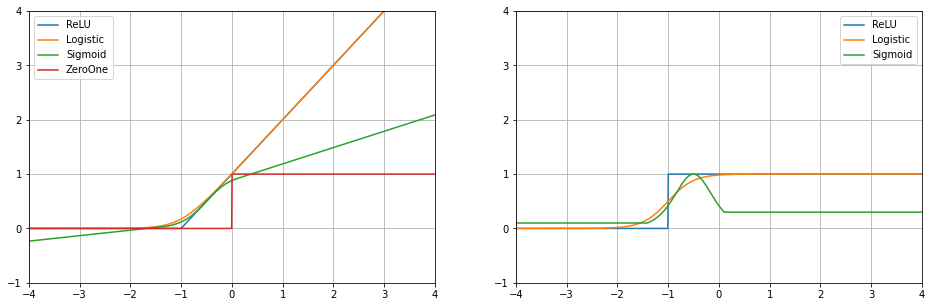

In [791]:
zero_one = lambda x : np.where(x > 0, 1, 0)
relu = ReLU(1)
leaky_relu = LeakyReLU(1, 0.25)
smooth_relu = SmoothReLU(1)
quadratic = Quadratic(1)
logistic = LeakyLogistic(1, 0)
sigmoid = LeakySigmoid(.5, .1, .3)

x = np.linspace(-4, 4, 1024, endpoint=True)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(x, relu.loss(x), label='ReLU')
#plt.plot(x, leaky_relu.loss(x), label='LeakyReLU')
#plt.plot(x, smooth_relu.loss(x), label='SmoothReLU')
#plt.plot(x, quadratic.loss(x), label='Quadratic')
plt.plot(x, logistic.loss(x), label='Logistic')
plt.plot(x, sigmoid.loss(x), label='Sigmoid')
plt.plot(x, zero_one(x), label='ZeroOne')
plt.legend()
plt.xlim(-4, 4)
plt.ylim(-1, 4)
plt.grid()

plt.subplot(122)
plt.plot(x, relu.grad(x), label='ReLU')
#plt.plot(x, leaky_relu.grad(x), label='LeakyReLU')
#plt.plot(x, smooth_relu.grad(x), label='SmoothReLU')
#plt.plot(x, quadratic.grad(x), label='Quadratic')
plt.plot(x, logistic.grad(x), label='Logistic')
plt.plot(x, sigmoid.grad(x), label='Sigmoid')
plt.legend()
plt.xlim(-4, 4)
plt.ylim(-1, 4)
plt.grid()

In [751]:
c = 1
n, d = X_train_scaled.shape
lr = .001
lr_up = ((1+np.sqrt(5))/2) ** (1/10)
lr_down = ((1+np.sqrt(5))/2) ** -1
armijo = .000001;
escale = 1
max_steps = 99
inner = LeakySigmoid(.5, 0, 1)
outer = LeakySigmoid(.5, 0, 1)

X = X_train_scaled
T = np.where(np.equal(Y_train[:, None], Y_train[None, :]), 1, -1)
N = np.sum(T == 1, 1) - 1

V = np.minimum(T, 0)
U = V + V.T
W = -(X.T @ (np.diag(np.sum(U, 0)) - U) @ X)
W /= np.sqrt(np.sum(np.square(W)))
P = X @ W @ X.T
D = P.diagonal()[:, None]
e = np.sum(np.maximum(T, 0) * (D + D.T - 2 * P)) / np.sum(N)
c /= n

print("step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e")

L, dW, de = loss_grad(X, T, N, W, e, c, inner, outer)
for i in range(max_steps+1):
    W_norm_squared = np.sum(np.square(W))
    LOOE = (L - W_norm_squared / 2) / c / n
    print(f"{i:4d} {lr:.3e} {-np.mean(dW):12.3f} {-de:12.3f} {L:11.3f} {np.sqrt(W_norm_squared):5.3f} {LOOE:9.3f} {e:6.3f}")
    while True:
        W_new = W - lr * dW
        e_new = e - lr * escale * de
        #W_new = PSD(W_new)
        #e_new = np.maximum(e_new, 0)
        L_new, dW_new, de_new = loss_grad(X, T, N, W_new, e_new, c, inner, outer)
        if L - L_new >= armijo * lr * (np.sum(np.square(dW)) + lr * escale * np.square(de)):
            L, dW, de = L_new, dW_new, de_new
            W, e = W_new, e_new
            lr *= lr_up
            break
        else:
            lr *= lr_down
            
print("step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e")


step  lrn_rate      dW_mean           de        loss W_nrm    L_mean      e
   0 1.000e-03       -5.673       15.716      62.004 1.000    61.504  3.510
   1 1.049e-03       -2.623        3.551      33.442 0.891    33.046  3.526
   2 1.101e-03       -0.957       -0.343      24.247 0.840    23.894  3.530
   3 1.155e-03       -0.681       -1.308      19.115 0.812    18.786  3.529
   4 1.212e-03       -0.081       -2.699      15.124 0.793    14.809  3.528
   5 1.272e-03       -0.093       -2.838      12.288 0.786    11.979  3.525
   6 1.335e-03       -0.058       -3.072      10.292 0.784     9.986  3.521
   7 1.401e-03       -0.054       -3.051       8.888 0.785     8.579  3.517
   8 1.470e-03       -0.039       -2.885       7.862 0.790     7.551  3.513
   9 1.542e-03        0.248       -3.003       7.029 0.795     6.714  3.508
  10 1.618e-03       -0.164       -2.633       6.312 0.802     5.991  3.504
  11 1.698e-03        0.244       -2.721       5.798 0.808     5.472  3.500
  12 1.781e-

In [798]:
A = np.arange(4).reshape(2, 2)
A.reshape(-1)
A.ravel()
A.flatten()

array([0, 1, 2, 3])